- 아주 specific한 에이전트를 개발하는 경우 유리
- 답변 생성 시 다양한 정보가 필요하다면 병렬 처리를 통해 시간 절약 가능

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str  # 사용자 질문
    answer: str  # 세율
    tax_base_equation: str  # 과세표준 계산 수식
    tax_deduction: str  # 공제액
    market_ratio: str  # 공정 시장 가액 비율
    tax_base: str  # 과세표준

graph_builder = StateGraph(AgentState)

In [3]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax_collection',
    persist_directory = './real_estate_tax_collection'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})


In [4]:
query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때, 세금을 얼마나 내나요?"

In [5]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

rag_prompt = hub.pull("rlm/rag-prompt")



/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
tax_base_retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()} | rag_prompt | llm | StrOutputParser()
)

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ("system", "사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연 설명 없이 수식만 나타내 주세요."),
    ("user", "{tax_base_equation_information}")
])

tax_base_equation_chain = (
    {"tax_base_equation_information": RunnablePassthrough()} | tax_base_equation_prompt | llm | StrOutputParser()
)

tax_base_chain = {"tax_base_equation_information": tax_base_retrieval_chain} | tax_base_equation_chain

def get_tax_base_equation(state: AgentState) -> AgentState:
    """
    종합부동산세 과세표준 계산 수식
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 
    고정된 기능을 수행하기 때문에 `state` 활용 X

    Args:
        state (AgentState): 현재 에이전트의 상태를 나타내는 객체

    Returns:
        AgentState: 'tax_base_equation' 키를 포함하는 새로운 `state` 반환
    """
    # 과세표준을 계산하는 방법을 묻는 질문 정의
    tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'
    
    # tax_base_chain을 사용하여 질문 실행 및 결과 추출
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    
    # state에서 'tax_base_equation' 키에 대한 값 반환
    return {'tax_base_equation': tax_base_equation}

In [7]:
get_tax_base_equation({})

{'tax_base_equation': '과세표준 = (∑(주택의 공시가격) - 공제금액) × 적용비율'}

- LLM은 번역, 요약, 분석에 능하지만 이들을 한 번에 수행하는 것은 잘 하지 못함

In [8]:
tax_deduction_chain = (
    {"context": retriever, "question": RunnablePassthrough()} | rag_prompt | llm | StrOutputParser()
)

def get_tax_deduction(state: AgentState) -> AgentState:
    """
    종합부동산세 공제금액에 관한 정보 추출
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 
    고정된 기능을 수행하기 때문에 `state` 활용 X

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체

    Returns:
        AgentState: 'tax_deduction' 키를 포함하는 새로운 state 반환
    """
    # 공제금액을 묻는 질문 정의
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요'
    
    # tax_deduction_chain을 사용하여 질문 실행 및 결과 추출
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    
    # state에서 'tax_deduction' 키에 대한 값 반환
    return {'tax_deduction': tax_deduction}

In [9]:
get_tax_deduction({})

{'tax_deduction': '주택에 대한 종합부동산세 계산 시 1세대 1주택자의 경우, 12억 원이 공제됩니다.'}

In [10]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ("system", f"아래 정보를 기반으로 사용자의 질문에 답변해주세요.\n\nContext:\n{{context}}"),
    ("human", "{query}")
])

def get_market_ratio(state: AgentState) -> AgentState:
    """
    web 검색을 통해 주택 공시가격에 대한 공정시장가액비율 추출
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 
    고정된 기능을 수행하기 때문에 `state` 활용 X
    
    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체

    Returns:
        AgentState: 'market_ratio' 키를 포함하는 새로운 state 반환
    """
    # 오늘 날짜에 해당하는 공정시장가액비율을 묻는 쿼리 정의
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇%인가요?'
    
    # tavily_search_tool을 사용하여 쿼리 실행 및 컨텍스트 추출
    context = tavily_search_tool.invoke(query)
    
    # tax_market_ratio_chain 구성 및 쿼리와 컨텍스트 처리
    tax_market_ratio_chain = (
        tax_market_ratio_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_market_ratio_chain 사용하여 시장 비율 계산
    market_ratio = tax_market_ratio_chain.invoke({'context': context, 'query': query})
    
    # state에서 'market_ratio' 키에 대한 값 반환
    return {'market_ratio': market_ratio}


In [11]:
get_market_ratio({})

{'market_ratio': '죄송하지만 2025년 1월 31일 기준으로 주택 공시가격 공정시장가액비율에 대한 정보는 제공되어 있지 않습니다. 최신 정보를 얻기 위해 공식 정부 발표나 관련 기관의 공식 웹사이트를 확인하시기 바랍니다.'}

In [12]:
from langchain_core.prompts import PromptTemplate

tax_base_calculation_prompt = PromptTemplate.from_template("""
주어진 내용을 기반으로 과세 표준을 계산해주세요.
과세 표준 계산 공식: {tax_base_equation}
공제액: {tax_deduction}
공정시장가액비율: {market_ratio}
사용자 주택 공시 가격 정: {query}
""")

def calculate_tax_base(state: AgentState):
    """
    주어진 state에서 과세표준 계산

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체

    Returns:
        AgentState: 'tax_base' 키를 포함하는 새로운 state 반환
    """
    # state에서 필요한 정보 추출
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    
    # tax_base_calculation_chain 구성 및 과세표준 계산
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_base_calculation_chain 사용하여 과세표준 계산
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })

    # state에서 'tax_base' 키에 대한 값 반환
    return {'tax_base': tax_base}

In [13]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요

종합부동산세 세율:{context}'''),
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요

과세표준: {tax_base}
주택 수:{query}''')
])

def calculate_tax_rate(state: AgentState):
    """
    주어진 state에서 세율 계산 함수입니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체

    Returns:
        dict: 'answer' 키를 포함하는 새로운 state를 반환
    """
    # state에서 필요한 정보를 추출
    query = state['query']
    tax_base = state['tax_base']
    
    # retriever를 사용하여 쿼리를 실행하고 컨텍스트 추출
    context = retriever.invoke(query)
    
    # tax_rate_chain을 구성하여 세율 계산
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_rate_chain을 사용하여 세율 계산
    tax_rate = tax_rate_chain.invoke({
        'context': context, 
        'tax_base': tax_base, 
        'query': query
    })

    # state에서 'answer' 키에 대한 값을 반환
    return {'answer': tax_rate}

In [14]:
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [15]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [16]:
graph = graph_builder.compile()

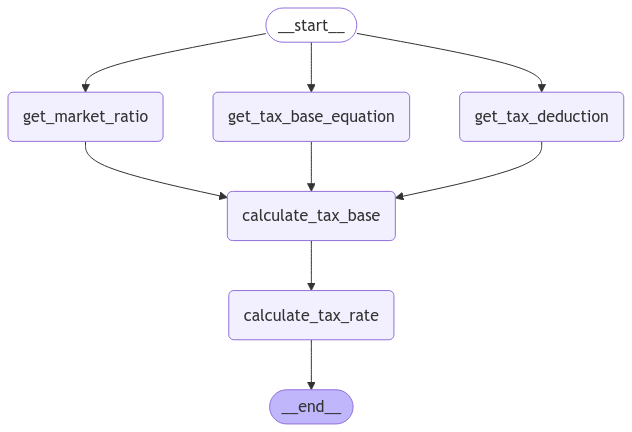

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
initial_state = {'query': query}
graph.invoke(initial_state)

{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때, 세금을 얼마나 내나요?',
 'answer': '귀하께서는 3채의 주택을 소유하고 있으므로 "납세의무자가 3주택 이상을 소유한 경우"에 해당합니다. 이 경우, 주어진 과세표준 21억 원에 적용될 종합부동산세율을 적용하여 세액을 계산할 수 있습니다.\n\n"납세의무자가 3주택 이상을 소유한 경우"의 세율은 다음과 같습니다:\n- 3억 원 이하: 1.2%\n- 3억 초과 6억 원 이하: 1.5%\n- 6억 초과 12억 원 이하: 1.8%\n- 12억 초과 50억 원 이하: 2.0%\n\n주어진 총 과세표준 21억 원의 경우, 각 구간에 따라 세금을 계산하면 다음과 같습니다:\n\n1. 3억 원까지: 3억 원 * 1.2% = 0.036억 원\n2. 3억 초과 6억 원까지: 3억 원 * 1.5% = 0.045억 원\n3. 6억 초과 12억 원까지: 6억 원 * 1.8% = 0.108억 원\n4. 12억 초과 21억 원까지: 9억 원 * 2.0% = 0.18억 원\n\n각 구간의 세금을 합산하여 총 종합부동산세를 계산하면:\n0.036억 원 + 0.045억 원 + 0.108억 원 + 0.18억 원 = 0.369억 원\n\n따라서 귀하께서 납부해야 할 종합부동산세는 약 3,690만 원입니다.',
 'tax_base_equation': '과세표준 = 공시가격 - 공제금액',
 'tax_deduction': '주택에 대한 종합부동산세 계산 시, 1세대 1주택자는 과세표준에서 12억 원을 공제받을 수 있습니다.',
 'market_ratio': '2025년 주택의 공정시장가액비율은 지방세법 시행령에 의해 주택은 60%로 정해져 있습니다.',
 'tax_base': '주어진 정보에 따라, 여러 주택을 소유하고 계시기 때문에 귀하는 1세대 1주택자로 간주되지 않습니다. 따라서 공제금액을 적용할 수 없으며 각 주택의 과세 표준을 따로 계산한 후 합산해야 합니다. 공정시장가액비율이 6